In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
img = cv2.imread('problem2/rgbn.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
depth_map = cv2.imread('problem2/depthn.png', cv2.IMREAD_GRAYSCALE)

In [3]:
K = np.array([[525.0, 0, 319.5], [0, 525.0, 239.5], [0, 0, 1]])
K_inv = np.linalg.inv(K)

In [4]:
# function to convert all points in image to 3D
# similar to the above function 
def all_points_to_3d(depth_map):
    pts_3d = []
    
    for x in range(depth_map.shape[0]):
        for y in range(depth_map.shape[1]):
            d = depth_map[x,y]
            
            #if d == 0:
                #continue
            
            # convert all points to homogeneous
            homogeneous = np.array([x, y, 1])
            
            # normalize
            normalized = K_inv.dot(homogeneous)
            
            # convert to world coordinates
            world = d * normalized
            
            # scaling
            point_3d = world / 5000
            pts_3d.append(point_3d)
        
    return np.array(pts_3d)

In [5]:
points3d = all_points_to_3d(depth_map)

In [6]:
points3d.shape

(307200, 3)

In [7]:
points3d = points3d.reshape(img.shape[0], img.shape[1], 3)

In [8]:
points3d.shape

(480, 640, 3)

In [9]:
def normal_mapping(img, points3d, verbose=False):
    # get image dimensions
    r, c, _ = img.shape

    # initialize normal map
    normal_map = np.zeros((r, c, 3), dtype=np.uint8)
    
    for x in range(r):
        for y in range(c):
            # if depth is zero, set normal to [0,0,0]
            if points3d[x,y,2] == 0:
                normal = np.array([0,0,0])
            else:
                # 7x7 neighborhood
                x_min = max(0, x - 3)
                x_max = min(r - 1, x + 3)
                y_min = max(0, y - 3)
                y_max = min(c - 1, y + 3)

                neighborhood = points3d[x_min:x_max+1, y_min:y_max+1, :]
                
                # get the non-zero points in the neighborhood
                non_zero_points = neighborhood[np.nonzero(neighborhood[:,:,2])]

                # if not enough non collinear points, set normal to [0,0,0]
                if non_zero_points.shape[0] < 3:
                    normal = np.array([0,0,0])
                
                # otherwise, fit plane to non-zero points
                else:
                    A = np.c_[non_zero_points[:,0], non_zero_points[:,1], np.ones(non_zero_points.shape[0])]
                    b = non_zero_points[:,2].reshape(-1, 1)
                    plane_params, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

                    normal = np.array([-plane_params[0,0], -plane_params[1,0], 1])
                    
                    # condition to check when both n and -n are solutions
                    if plane_params[2] < 0:
                        normal *= -1

                    normal /= np.linalg.norm(normal)
            
            # adding color
            color = ((0.5 * normal / np.linalg.norm(normal) + 0.5) * 255).astype(np.uint8)
            normal_map[x, y, :] = color

    if verbose == True:
        plt.title("Normal Mapping")
        plt.imshow(normal_map)
        plt.axis('off')
        plt.show()
    
    return normal_map

C:\Users\alexr\AppData\Local\Temp\ipykernel_28384\1386975173.py:44: RuntimeWarning: invalid value encountered in divide
  color = ((0.5 * normal / np.linalg.norm(normal) + 0.5) * 255).astype(np.uint8)
C:\Users\alexr\AppData\Local\Temp\ipykernel_28384\1386975173.py:44: RuntimeWarning: invalid value encountered in cast
  color = ((0.5 * normal / np.linalg.norm(normal) + 0.5) * 255).astype(np.uint8)


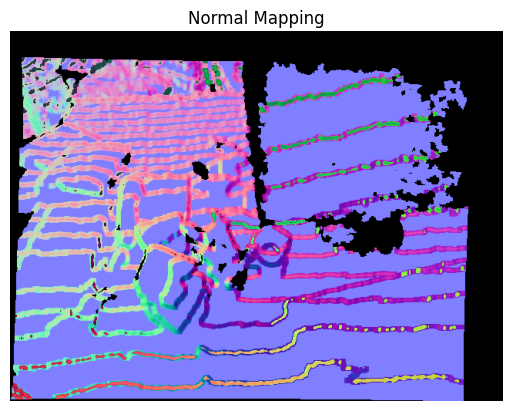

In [10]:
nm = normal_mapping(img, points3d, verbose=True)

In [11]:
nm = cv2.cvtColor(nm, cv2.COLOR_BGR2RGB)
cv2.imwrite("normal_mapping.png", nm)

True